# Correlation and information content

In [1]:
using BitInformation, PyPlot, ColorSchemes
using PyPlot, ProgressMeter, Statistics

In [2]:
using TranscodingStreams, CodecZstd

ZstdCompressorL10 = ZstdCompressor(level=10)
TranscodingStreams.initialize(ZstdCompressorL10)

ZstdCompressorL22 = ZstdCompressor(level=22)
TranscodingStreams.initialize(ZstdCompressorL22)

In [3]:
function ar1process(r::T,N::Int) where T
    
    ar1 = Array{T}(undef,N)        # preallocate
    ar1[1] = convert(T,randn())    # initial conditions
    s = sqrt(1-r^2)                # noise magnitude
    
    for i in 2:N
        ar1[i] = r*ar1[i-1] + s*randn(T)
    end
    
    return ar1
end

ar1process (generic function with 1 method)

In [4]:
function keepbits(bi::Array{T},p::Real=0.99) where T
    n_signexp = length(bi) == 32 ? 9 : 12
    return argmax(cumsum(bi)/sum(bi) .>= p) - n_signexp
end

keepbits (generic function with 2 methods)

## Loop over autocorrelation

In [5]:
# options
N = 1_000_000
Nens = 51
autocorrs = 1 .- 10.0 .^(-6:0.1:0)
Nautocorr = length(autocorrs)
Nbits = 32;

In [6]:
# preallocate
K1 = fill(0.0,Nens,Nautocorr)     # keepbits
K2 = fill(0.0,Nens,Nautocorr)     # keepbits
K3 = fill(0.0,Nens,Nautocorr)     # keepbits
X1 = fill(0.0,Nens,Nautocorr);     # compression factors
X2 = fill(0.0,Nens,Nautocorr);     # compression factors
X3 = fill(0.0,Nens,Nautocorr);     # compression factors

B1 = fill(0.0,Nbits,Nens,Nautocorr)
B2 = fill(0.0,Nbits,Nens,Nautocorr);

In [7]:
@showprogress for (i,r) in enumerate(autocorrs)
    for iens in 1:Nens
        ar1 = convert.(Float32,ar1process(r,N))
        bi = bitinformation(ar1)
        B1[:,iens,i] = bi
        kb = keepbits(bi)
        K1[iens,i] = kb
        
        ar1r = round(ar1,kb)
        X1[iens,i] = 2*sizeof(ar1r)/sizeof(transcode(ZstdCompressorL10,copy(reinterpret(UInt8,ar1r))))
        
        bi = bitinformation(ar1 .+ 10)
        B2[:,iens,i] = bi
        kb = keepbits(bi)
        K2[iens,i] = kb
        
        ar1r = round(ar1 .+ 10,kb)
        X2[iens,i] = 2*sizeof(ar1r)/sizeof(transcode(ZstdCompressorL10,copy(reinterpret(UInt8,ar1r))))
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:14:11


In [8]:
sort!(K1,dims=1)
sort!(K2,dims=1)
sort!(K3,dims=1)

sort!(X1,dims=1)
sort!(X2,dims=1)
sort!(X3,dims=1);

In [9]:
B1mean = mean(B1,dims=2)[:,1,:]
B1mean[B1mean .< 1e-2] .= NaN;

B2mean = mean(B2,dims=2)[:,1,:]
B2mean[B2mean .< 1e-2] .= NaN;

## Plotting

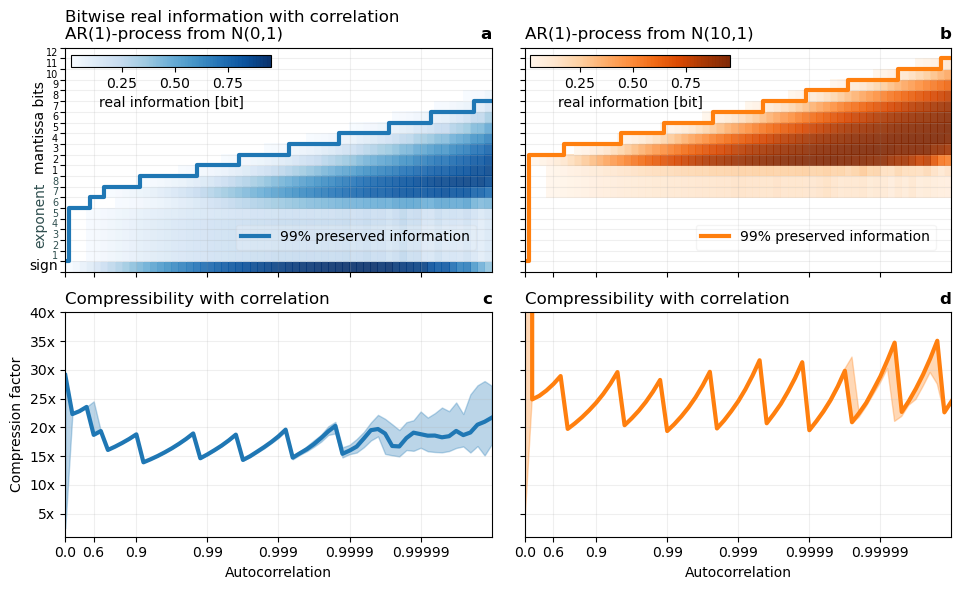

sys:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [11]:
fig,axs = subplots(2,2,sharex=true,figsize=(10,6))

ax1 = axs[1,1]
ax2 = axs[2,1]
ax1b = axs[1,2]
ax2b = axs[2,2]

cax1 = fig.add_axes([0.076,0.88,0.2,0.02])
cax1b = fig.add_axes([0.535,0.88,0.2,0.02])

# keepbits
ax1b.plot(-log10.(1 .- autocorrs),K2[(Nens+1)÷2,:],"C1",lw=3,ds="steps-mid",label="99% preserved information")
ax1.plot(-log10.(1 .- autocorrs),K1[(Nens+1)÷2,:],"C0",lw=3,ds="steps-mid",label="99% preserved information")

q1 = ax1.pcolormesh(vcat(-log10.(1 .- autocorrs),1),collect(0:32).-9,B1mean,cmap="Blues",alpha=.9)
q1b = ax1b.pcolormesh(vcat(-log10.(1 .- autocorrs),1),collect(0:32).-9,B2mean,cmap="Oranges",alpha=.9)

colorbar(q1,cax=cax1,orientation="horizontal",label="real information [bit]")
colorbar(q1b,cax=cax1b,orientation="horizontal",label="real information [bit]")

# compression factors
ax2b.plot(-log10.(1 .- autocorrs),X2[(Nens+1)÷2,:],"C1",lw=3,label="AR(1)-process from N(10,1)")
ax2.plot(-log10.(1 .- autocorrs),X1[(Nens+1)÷2,:],"C0",lw=3,label="AR(1)-process from N(0,1)")
# ax2.plot(-log10.(1 .- autocorrs),X3[(Nens+1)÷2,:],"indigo",lw=3,label="AR(1)-process from N(0,10)")

ax2.fill_between(-log10.(1 .- autocorrs),
            X1[round(Int,Nens/10),:],X1[round(Int,Nens*9/10),:],alpha=.3,color="C0")
ax2b.fill_between(-log10.(1 .- autocorrs),
            X2[round(Int,Nens/10),:],X2[round(Int,Nens*9/10),:],alpha=.3,color="C1")
# ax2.fill_between(-log10.(1 .- autocorrs),
#             X3[round(Int,Nens/10),:],X3[round(Int,Nens*9/10),:],alpha=.3,color="indigo")

tiks = [0,0.6,0.9,0.99,0.999,0.9999,0.99999]
ax1.set_xticks(-log10.(1 .- tiks))
ax1.set_xticklabels(tiks)
ax1.set_xlim(extrema(-log10.(1 .- autocorrs)))

ax1.set_yticks(-9:12)
ax1.set_yticklabels([])
ax1.set_ylim(-9,12)
ax1.legend(loc=(0.4,0.1),framealpha=.2)
ax1.text(-0.1,-8.8,"sign",ha="right")
ax1.text(-0.45,-6.5,"exponent",color="darkslategrey",rotation=90)
ax1.text(-0.45,0.5,"mantissa bits",rotation=90)

for i in 1:8
    ax1.text(-0.10,-8.8+i,"$i",ha="right",fontsize=7,color="darkslategrey")
end

for i in 1:12
    ax1.text(-0.1,-0.8+i,"$i",ha="right",fontsize=7)
end

ax1b.set_yticks(-9:12)
ax1b.set_ylim(-9,12)
ax1b.set_yticklabels([])
ax1b.legend(loc=(0.4,0.1),framealpha=.2)

ax2.set_ylim(1,40)
ax2.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%dx"))
ax2b.set_ylim(1,40)
ax2b.set_yticklabels([])

ax1.grid(alpha=.2)
ax2.grid(alpha=.2)
ax1b.grid(alpha=.2)
ax2b.grid(alpha=.2)

ax1.set_title("Bitwise real information with correlation\nAR(1)-process from N(0,1)",loc="left")
ax1b.set_title("AR(1)-process from N(10,1)",loc="left")
ax2.set_title("Compressibility with correlation",loc="left")
ax2b.set_title("Compressibility with correlation",loc="left")
ax2.set_ylabel("Compression factor")
ax2.set_xlabel("Autocorrelation")
ax2b.set_xlabel("Autocorrelation")

for (iax,ax) in enumerate([ax1,ax1b,ax2,ax2b])
    ax.set_title(string(Char(96+iax)),loc="right",fontweight="bold")
end

tight_layout(w_pad=0)
savefig("correlation_ar1.png",dpi=200)
savefig("correlation_ar1.pdf")